In [1]:
import pandas as pd
import numpy as np
from plotnine import *

In [2]:
pop = pd.read_csv("../20_intermediate_files/cleaned_population.csv")
death_rate = pd.read_csv("../20_intermediate_files/death_rate.csv")
opioids = pd.read_csv("../20_intermediate_files/opioids_clean.csv")

In [3]:
pop

,state,county,year,total_population
0,AL,autauga,2000,43872
1,AL,baldwin,2000,141358
2,AL,barbour,2000,29035
3,AL,bibb,2000,19936
4,AL,blount,2000,51181
...,...,...,...,...
62255,WY,sweetwater,2019,42343
62256,WY,teton,2019,23464
62257,WY,uinta,2019,20226
62258,WY,washakie,2019,7805


In [4]:
pop.rename(columns = {"year": "Year"}, inplace = True)

In [5]:
# Additional data cleaning before merge
## Additional treatment for overdose deaths dataset
death_rate["state"] = death_rate["state"].str.lstrip()
death_rate["county"] = death_rate["county"].str.rstrip()

death_rate = death_rate[(death_rate["state"] != "DC") | (death_rate["state"] != "AK")]

death_rate = death_rate.loc[death_rate['Deaths']!='Missing']

## Additional treatment for population dataset
pop = pop[(pop["Year"]>=2003) & (pop["Year"] <= 2015)]

In [6]:
# Change the data type of death_rate.Deaths, str to float
death_rate.Deaths = death_rate.Deaths.astype(float)

In [7]:
opioids

,state,county,Year,Month,weight
0,CT,fairfield,2006,1,4287.48
1,CT,fairfield,2006,2,16921.56
2,CT,fairfield,2006,3,19598.62
3,CT,fairfield,2006,4,17400.30
4,CT,fairfield,2006,5,20785.91
...,...,...,...,...,...
248745,WY,weston,2012,8,155.93
248746,WY,weston,2012,9,165.05
248747,WY,weston,2012,10,230.79
248748,WY,weston,2012,11,233.76


In [6]:
# opioids_year = opioids.groupby(["Year","state"]).sum()['weight'].reset_index()
# death_year = death_rate.groupby(["Year","state"]).sum()['Deaths'].reset_index()
# pop_year = pop.groupby(["Year","state"]).sum()['total_population'].reset_index()

In [10]:
# Merge
pop_opi = pop.merge(opioids, on = ["Year", "state", "county"], how = "left")
final = pop_opi.merge(death_rate, on = ["state", "Year", "county"], how = "left")

In [11]:
final['opioid_per_cap'] = final['weight']/final['total_population']
final['mortality_rate_in_100k'] = final['Deaths']/final['total_population']*100000

In [12]:
final

,state,county,Year,total_population,Month,weight,Drug/Alcohol Induced Cause Code,Deaths,opioid_per_cap,mortality_rate_in_100k
0,AL,autauga,2003,45762,NaN,NaN,NaN,NaN,NaN,NaN
1,AL,baldwin,2003,151707,NaN,NaN,D1,10.0,NaN,6.591654
2,AL,barbour,2003,29480,NaN,NaN,NaN,NaN,NaN,NaN
3,AL,bibb,2003,21037,NaN,NaN,NaN,NaN,NaN,NaN
4,AL,blount,2003,53726,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
261020,WY,sweetwater,2015,44754,NaN,NaN,NaN,NaN,NaN,NaN
261021,WY,teton,2015,23016,NaN,NaN,NaN,NaN,NaN,NaN
261022,WY,uinta,2015,20770,NaN,NaN,NaN,NaN,NaN,NaN
261023,WY,washakie,2015,8280,NaN,NaN,NaN,NaN,NaN,NaN


-------------

## Plotting

In [13]:
northeast = ['CT','ME','MA','NH','RI','VT','NJ','NY','PA']
midwest = ['IL','IN','MI','OH','WI','IA','KS','MN','MO','NE','ND','SD']
south = ['DE','FL','GA','MD','NC','SC','VA','WV','AL','KY','MS','TN','AR','LA','OK','TX']
west = ['AZ','CO','ID','MT','NV','NM','UT','WY','CA','HI','OR','WA']

### Florida

In [14]:
control = ['DE','GA','MD','NC','SC','VA','WV','AL','KY','MS','TN','AR','LA','OK']

In [15]:
# control_df = final[final.state.isin(control)].groupby(["Year"], as_index = False).mean()

In [16]:
control_df = final[final.state.isin(control)]

In [17]:
control_df = control_df.copy()
control_df["state"] = "control"

In [18]:
fl_df = pd.concat([final[final["state"] == "FL"], control_df]).reset_index(drop = True)
# fl_df["Year"] = pd.to_datetime(fl_df["Year"],format = "%Y")

In [19]:
fl_df["policy"] = 0
fl_df.loc[fl_df["Year"] > 2010, "policy"] = 1

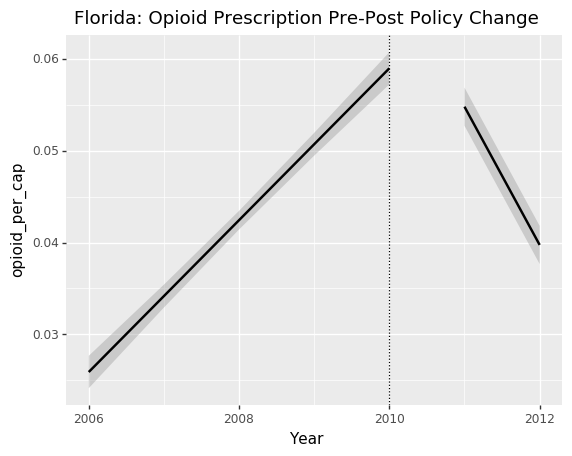

<ggplot: (8776907015337)>

In [20]:
(
    ggplot(fl_df[fl_df["state"] == "FL"], aes(x = "Year", y = "opioid_per_cap", group = "policy")) +
        geom_smooth(method  = "lm") +
        geom_vline(xintercept = 2010, linetype = "dotted") +
        ggtitle("Florida: Opioid Prescription Pre-Post Policy Change")
)

In [21]:
fl_df

,state,county,Year,total_population,Month,weight,Drug/Alcohol Induced Cause Code,Deaths,opioid_per_cap,mortality_rate_in_100k,policy
0,FL,alachua,2003,225862,NaN,NaN,D1,11.0,NaN,4.870230,0
1,FL,baker,2003,23285,NaN,NaN,NaN,NaN,NaN,NaN,0
2,FL,bay,2003,154726,NaN,NaN,D1,21.0,NaN,13.572380,0
3,FL,bradford,2003,27097,NaN,NaN,NaN,NaN,NaN,NaN,0
4,FL,brevard,2003,502985,NaN,NaN,D1,83.0,NaN,16.501486,0
...,...,...,...,...,...,...,...,...,...,...,...
97446,control,webster,2015,8636,NaN,NaN,NaN,NaN,NaN,NaN,1
97447,control,wetzel,2015,15777,NaN,NaN,NaN,NaN,NaN,NaN,1
97448,control,wirt,2015,5805,NaN,NaN,NaN,NaN,NaN,NaN,1
97449,control,wood,2015,86326,NaN,NaN,D1,22.0,NaN,25.484790,1


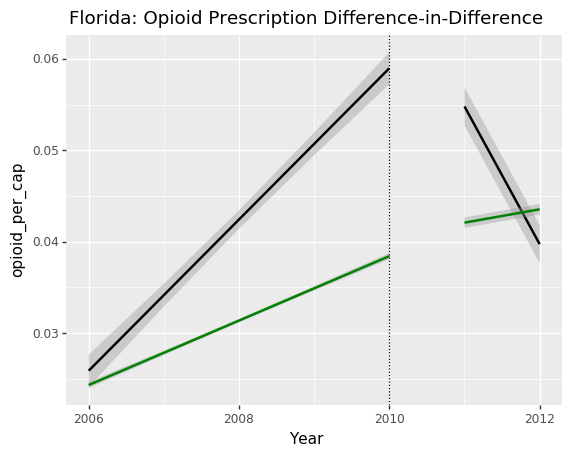

<ggplot: (8776908667961)>

In [22]:
(
    ggplot(fl_df) +
        geom_smooth(fl_df[fl_df["state"] == "FL"], aes(x = "Year", y = "opioid_per_cap", group = "policy"),method = "lm") +
        geom_smooth(fl_df[fl_df["state"] == "control"], aes(x = "Year", y = "opioid_per_cap", group = "policy"),
                    method = "lm", color = "green") +
        geom_vline(xintercept = 2010, linetype = "dotted") +
        ggtitle("Florida: Opioid Prescription Difference-in-Difference")
)

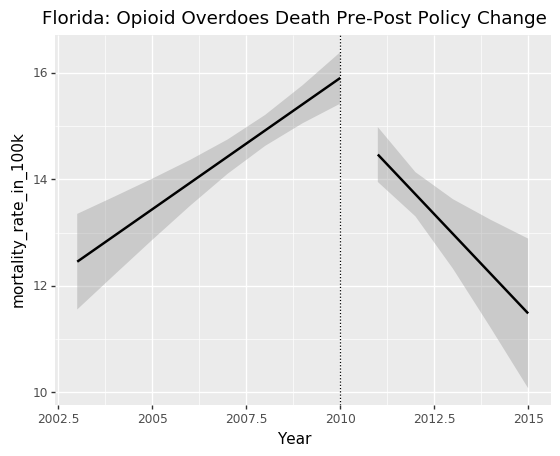

<ggplot: (8776883221281)>

In [23]:
(
    ggplot(fl_df[fl_df["state"] == "FL"]) +
        geom_smooth(aes(x = "Year", y = "mortality_rate_in_100k", group = "policy"), method  = "lm") +
        geom_vline(xintercept = 2010, linetype = "dotted") +
        ggtitle("Florida: Opioid Overdoes Death Pre-Post Policy Change") 
)

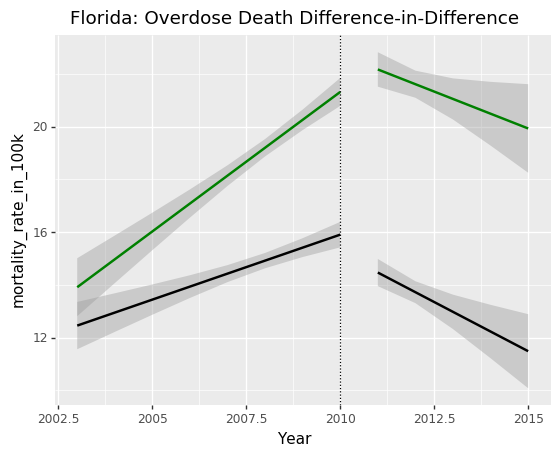

<ggplot: (8776908683865)>

In [24]:
(
    ggplot(fl_df) +
        geom_smooth(fl_df[fl_df["state"] == "FL"], aes(x = "Year", y = "mortality_rate_in_100k", group = "policy"),method = "lm") +
        geom_smooth(fl_df[fl_df["state"] == "control"], aes(x = "Year", y = "mortality_rate_in_100k", group = "policy"),
                    method = "lm", color = "green") +
        geom_vline(xintercept = 2010, linetype = "dotted") +
        ggtitle("Florida: Overdose Death Difference-in-Difference")
)

### Texas

In [25]:
tx_df = pd.concat([final[final["state"] == "TX"], control_df]).reset_index(drop = True)

In [26]:
tx_df["policy"] = 0
tx_df.loc[tx_df["Year"] > 2007, "policy"] = 1

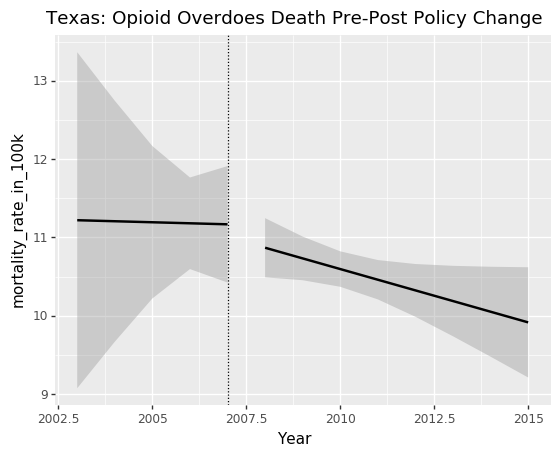

<ggplot: (8776882665573)>

In [27]:
(
     ggplot(tx_df[tx_df["state"] == "TX"]) +
        geom_smooth(aes(x = "Year", y = "mortality_rate_in_100k", group = "policy"), method  = "lm") +
        geom_vline(xintercept = 2007, linetype = "dotted") +
        ggtitle("Texas: Opioid Overdoes Death Pre-Post Policy Change") 
)

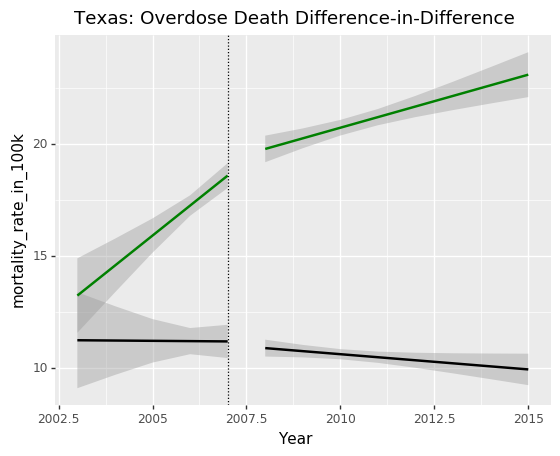

<ggplot: (8776883095989)>

In [28]:
(
    ggplot(tx_df) +
        geom_smooth(tx_df[tx_df["state"] == "TX"], aes(x = "Year", y = "mortality_rate_in_100k", group = "policy"),method = "lm") +
        geom_smooth(tx_df[tx_df["state"] == "control"], aes(x = "Year", y = "mortality_rate_in_100k", group = "policy"),
                    method = "lm", color = "green") +
        geom_vline(xintercept = 2007, linetype = "dotted")  +
        ggtitle("Texas: Overdose Death Difference-in-Difference")
)

### Washington

In [29]:
control = ['AZ','CO','ID','MT','NV','NM','UT','WY','CA','HI','OR']
control_df = final[final.state.isin(control)]
control_df = control_df.copy()
control_df["state"] = "control"

In [30]:
wa_df = pd.concat([final[final["state"] == "WA"], control_df]).reset_index(drop = True)
wa_df["policy"] = 0
wa_df.loc[wa_df["Year"] > 2012, "policy"] = 1

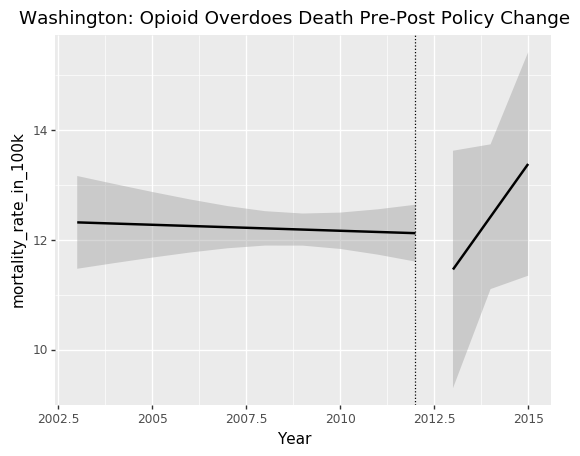

<ggplot: (8776885131377)>

In [31]:
(
    ggplot(wa_df[wa_df["state"] == "WA"]) +
        geom_smooth(aes(x = "Year", y = "mortality_rate_in_100k", group = "policy"), method  = "lm") +
        geom_vline(xintercept = 2012, linetype = "dotted") +
        ggtitle("Washington: Opioid Overdoes Death Pre-Post Policy Change") 
)

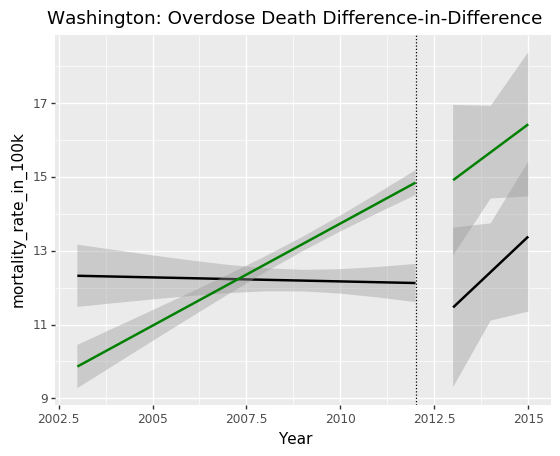

<ggplot: (8776885130805)>

In [32]:
(
    ggplot(wa_df) +
        geom_smooth(wa_df[wa_df["state"] == "WA"], aes(x = "Year", y = "mortality_rate_in_100k", group = "policy"),method = "lm") +
        geom_smooth(wa_df[wa_df["state"] == "control"], aes(x = "Year", y = "mortality_rate_in_100k", group = "policy"),
                    method = "lm", color = "green") +
        geom_vline(xintercept = 2012, linetype = "dotted") +
        ggtitle("Washington: Overdose Death Difference-in-Difference")
)